1番下のセルがアンサンブル用に変更したやつ
上2コのセルは気にしないでくだせえ

学習データ読み込み完了: (10000, 15)
モデルの学習が完了しました。

 ロジスティック回帰モデル 評価結果 
AUC (Area Under the Curve): 0.9138
Accuracy (正解率): 0.8585
----------------------------------------
Classification Report (Precision, Recall, F値):
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1510
           1       0.75      0.63      0.69       490

    accuracy                           0.86      2000
   macro avg       0.82      0.78      0.80      2000
weighted avg       0.85      0.86      0.85      2000

----------------------------------------
Confusion Matrix (混同行列):
[[1407  103]
 [ 180  310]]


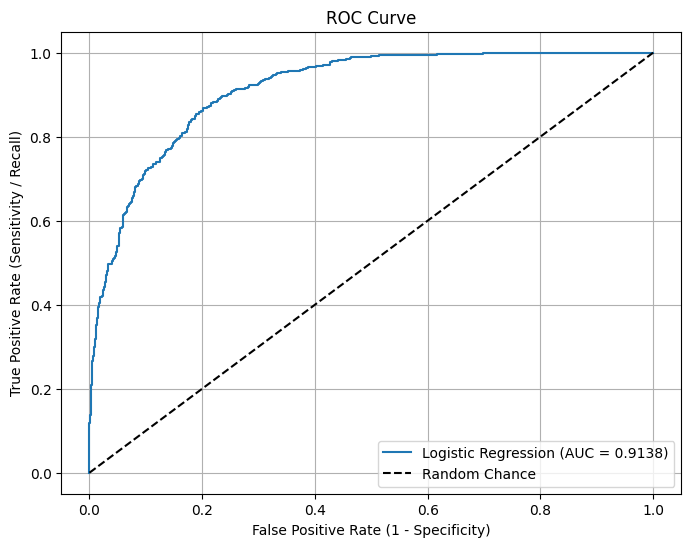

----------------------------------------
重要な変数 Top 5 (係数の絶対値):
                               feature  coefficient  abs_coef
3                         capital-gain     2.295708  2.295708
28  marital-status_ Married-civ-spouse     1.835064  1.835064
87            native-country_ Scotland    -1.086832  1.086832
48             relationship_ Own-child    -1.039256  1.039256
76             native-country_ Jamaica     1.035266  1.035266


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # グラフ描画用
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report

# --- 1. データ読み込み ---
# ファイルパスは環境に合わせて変更してください
# UnicodeDecodeErrorを解消するため、encoding='shift_jis' を追加
train_df = pd.read_csv('/content/drive/MyDrive/train_test_2025.csv', encoding='shift_jis')

# カラム名の確認と修正（ターゲット変数が全角の'ｙ'である可能性があるため対応）
target_col_original = train_df.columns[-1]
train_df = train_df.rename(columns={target_col_original: 'target'})

print(f"学習データ読み込み完了: {train_df.shape}")

# --- 2. 前処理 ---
# 特徴量とターゲットの分離
X = train_df.iloc[:, 0:14]
y = train_df['target']

# ターゲット変数の2値化 ('no' -> 0, 'yes' -> 1)
y = y.astype(str).str.strip().map({'no': 0, 'yes': 1})

# 変数の特定
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# 前処理パイプライン
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# --- 3. モデル構築用データの分割 ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 4. モデル定義と学習 ---
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(solver='liblinear', random_state=42))])

model.fit(X_train, y_train)
print("モデルの学習が完了しました。")

# --- 5. モデル評価 ---
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1] # クラス1 (yes) の確率

# 評価指標の計算
auc_score = roc_auc_score(y_val, y_pred_proba)

print("\n" + "="*40)
print(" ロジスティック回帰モデル 評価結果 ")
print("="*40)
print(f"AUC (Area Under the Curve): {auc_score:.4f}")
print(f"Accuracy (正解率): {accuracy_score(y_val, y_pred):.4f}")
print("-" * 40)

# Classification Report (Precision, Recall, F1-scoreなど)
print("Classification Report (Precision, Recall, F値):")
print(classification_report(y_val, y_pred))

# 混同行列
print("-" * 40)
print("Confusion Matrix (混同行列):")
cm = confusion_matrix(y_val, y_pred)
print(cm)

# --- ROC曲線の描画 ---
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance') # ランダムな場合の線
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity / Recall)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show() # グラフを表示

# 重要な変数の確認
feature_names = numeric_features.tolist() + \
                model.named_steps['preprocessor'].transformers_[1][1]\
                .named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
coefficients = model.named_steps['classifier'].coef_[0]
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})
coef_df['abs_coef'] = coef_df['coefficient'].abs()

print("-" * 40)
print("重要な変数 Top 5 (係数の絶対値):")
print(coef_df.sort_values(by='abs_coef', ascending=False).head(5))

In [ ]:
# --- 6. 提出用データへの予測 ---

# 提出用データの読み込み
# UnicodeDecodeErrorを解消するため、encoding='shift_jis' を追加
submit_df = pd.read_csv('/content/drive/MyDrive/submit_2025.csv', encoding='shift_jis')

# 特徴量の抽出 (A列～N列)
X_submit = submit_df.iloc[:, 0:14]

print(f"提出用データ読み込み完了: {submit_df.shape}")

# 学習済みモデルで予測を実行
# predict: クラス予測 (0 or 1)
# predict_proba: 確率予測
submit_pred_class = model.predict(X_submit)
submit_pred_proba = model.predict_proba(X_submit)[:, 1]

# --- 7. 結果の保存 ---
submit_output = submit_df.copy()

# カラム名の特定 (O列とP列に相当する部分)
# submit_dfの最後の2列がそれぞれ 'target(空)', 'probability' と想定
target_col_submit = submit_output.columns[-2]
prob_col_submit = submit_output.columns[-1]

# 予測クラスを yes/no に戻して格納
submit_output[target_col_submit] = np.where(submit_pred_class == 1, 'yes', 'no')

# 確率 (probability of yes) を格納
submit_output[prob_col_submit] = submit_pred_proba

# CSV出力
output_filename = '/content/drive/MyDrive/submit_prediction_logistic.csv'
submit_output.to_csv(output_filename, index=False)

print("\n" + "="*40)
print(f"予測完了！")
print(f"結果を '{output_filename}' に保存しました。")
print("先頭5行のプレビュー:")
print("-" * 40)
print(submit_output[[target_col_submit, prob_col_submit]].head())

提出用データ読み込み完了: (1000, 16)

予測完了！
結果を '/content/drive/MyDrive/submit_prediction_logistic.csv' に保存しました。
先頭5行のプレビュー:
----------------------------------------
     ｙ  probability of yes (or score)
0   no                       0.219858
1  yes                       0.513866
2   no                       0.012845
3   no                       0.006153
4  yes                       0.557953


Original Shape: (10000, 16)
ロジスティック回帰モデルの学習が完了しました。
検証用予測データを保存しました: /content/drive/MyDrive/valid_prediction_lr.csv

モデル評価レポート

ROC AUC Score: 0.9138

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1510
           1       0.75      0.63      0.69       490

    accuracy                           0.86      2000
   macro avg       0.82      0.78      0.80      2000
weighted avg       0.85      0.86      0.85      2000



<Figure size 600x500 with 0 Axes>

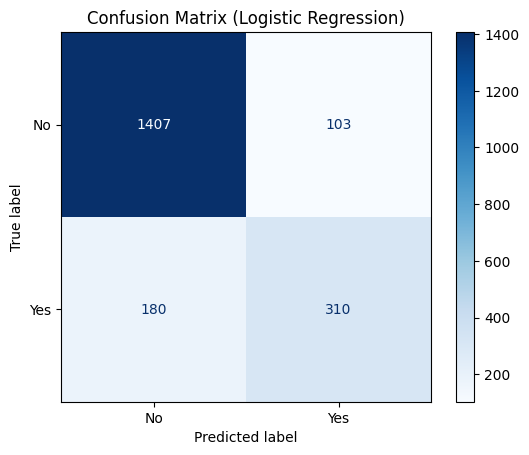

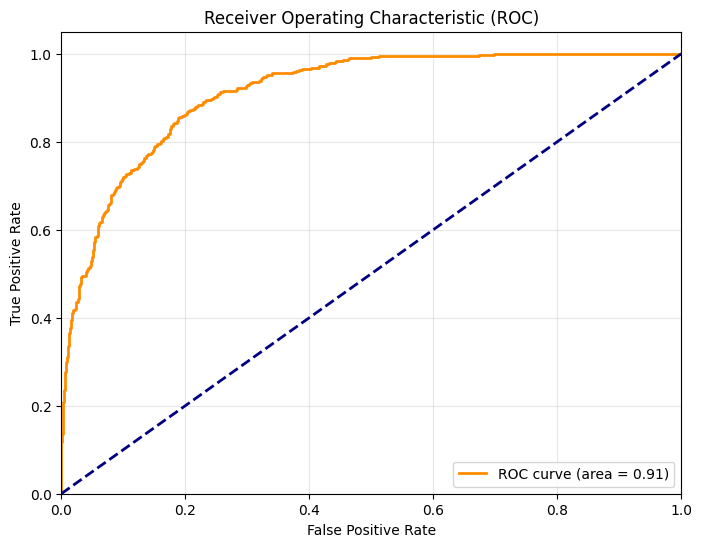


提出用予測データを保存しました: /content/drive/MyDrive/test_prediction_lr.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, roc_curve, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

# ==========================================
# 1. データの読み込み
# ==========================================
file_path = '/content/drive/MyDrive/train_test_2025.csv'

try:
    df = pd.read_csv(file_path, encoding='shift_jis')
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='cp932')

# ①データimport時にid付与
df['id'] = df.index

# ターゲット変数の名称統一
target_col_original = df.columns[-2]
df = df.rename(columns={target_col_original: 'target'})

print(f"Original Shape: {df.shape}")

# ==========================================
# 2. 前処理（学習データ）
# ==========================================
X = df.iloc[:, 0:14].copy()
y = df['target'].astype(str).str.strip().map({'no': 0, 'yes': 1})
ids = df['id']

# 必要に応じて不要列削除（今回は例としてコメントアウト）
# cols_to_drop = ['education', 'fnlwgt']
# X = X.drop(columns=[c for c in cols_to_drop if c in X.columns])

# 変数タイプの抽出
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# パイプライン構築
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# ==========================================
# 3. データ分割
# ==========================================
# ②モデル学習時にidは外すが、分割時はidも維持
X_train, X_val, y_train, y_val, id_train, id_val = train_test_split(
    X, y, ids,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# ==========================================
# 4. モデル学習
# ==========================================
model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

model_lr.fit(X_train, y_train)
print("ロジスティック回帰モデルの学習が完了しました。")

# ==========================================
# 5. 検証用データの予測と評価 (③ + 追加要件)
# ==========================================
y_val_probs = model_lr.predict_proba(X_val)[:, 1]
best_threshold = 0.5
y_val_pred = (y_val_probs >= best_threshold).astype(int)

# --- CSV出力用 ---
df_valid_output = pd.DataFrame({
    'id': id_val,
    'Actual': y_val,
    'LR_Probability': y_val_probs,
    'LR_Prediction': y_val_pred
})
valid_output_path = '/content/drive/MyDrive/valid_prediction_lr.csv'
df_valid_output.to_csv(valid_output_path, index=False)
print(f"検証用予測データを保存しました: {valid_output_path}")

# --- 【追加】評価指標の提示 ---
print("\n" + "="*40)
print("モデル評価レポート")
print("="*40)

# 1. AUCスコア
auc_score = roc_auc_score(y_val, y_val_probs)
print(f"\nROC AUC Score: {auc_score:.4f}")

# 2. Classification Report (Precision, Recall, F1)
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

# 3. 混同行列 (Confusion Matrix) の可視化
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()

# 4. ROC曲線の可視化

fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# ==========================================
# 6. 提出用データ(submit)の予測と出力 (④)
# ==========================================
submit_file_path = '/content/drive/MyDrive/submit_2025.csv'

try:
    df_submit = pd.read_csv(submit_file_path, encoding='shift_jis')
except UnicodeDecodeError:
    df_submit = pd.read_csv(submit_file_path, encoding='cp932')

df_submit['id'] = df_submit.index
submit_ids = df_submit['id']

X_submit = df_submit.iloc[:, 0:14].copy()
submit_probs = model_lr.predict_proba(X_submit)[:, 1]

df_submit_output = pd.DataFrame({
    'id': submit_ids,
    'LR_Probability': submit_probs,
    'LR_Prediction': (submit_probs >= best_threshold).astype(int)
})

submit_output_path = '/content/drive/MyDrive/test_prediction_lr.csv'
df_submit_output.to_csv(submit_output_path, index=False)

print(f"\n提出用予測データを保存しました: {submit_output_path}")